# 1 Sequences Scrapping - Introduction
This notebook is an automated tool designed for retrieving 16S rRNA sequences from the GenBank database, managed by the National Center for Biotechnology Information (NCBI). The focus is on sequences associated with various genera found in water bodies, as part of a broader study.

# Key Steps and Features:
### Reading Genera List:
The script starts by reading a list of genera from an Excel file. These genera are of particular interest for the study.
### NCBI Database Interaction:
It establishes a connection with the NCBI database and iteratively queries each genus. This process involves fetching the unique identifiers (accession numbers) of the relevant 16S rRNA sequences.
### Data Storage and Organization:
The retrieved data, mainly accession numbers, are stored in a dictionary for subsequent processing.
### Sequence Retrieval and Verification:
The notebook includes a function for fetching the actual sequence data from GenBank using the accession numbers. There's also a provision for validating the retrieved sequences.
### Data Manipulation:
Extensive data manipulation is performed, including transforming and merging dataframes to align the sequence data with the original genera list.
### Phylogenetic Analysis:
The primary goal is to align these sequences to construct a dendrogram, offering insights into the genomic relationships among the genera.
The notebook implements the UPGMA (Unweighted Pair Group Method with Arithmetic Mean) method for tree construction, with a mention of the possibility of using Neighbor-Joining (NJ).
The script includes steps for sequence alignment, conversion to FASTA format, and preparation for phylogenetic tree construction.
### Bootstrap Analysis for Tree Reliability:
To assess the reliability of the phylogenetic trees, a bootstrap analysis is performed. This involves generating multiple pseudo-replicated datasets and analyzing the resulting tree structures.
### Consensus Tree Construction:
A consensus tree is constructed from the bootstrap trees, providing a robust representation of the phylogenetic relationships.
### Additional Notes:
The script contains several safety and optimization measures, such as using time.sleep to avoid overloading the NCBI server and handling exceptions during sequence retrieval.
There's a focus on improving the script, including suggestions for secure API key storage, error handling enhancements, and code documentation.

I am having problems installilng packages from the terminal, so I am installing the biophyton from here.

# 2. Preprocessing the data 
This notebook has been worked in colab and in vsc, the code is silence eitherway.
## 2.1 Mounting the data in colab

In [11]:
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC')'''

"from google.colab import drive  #silence for vscode\ndrive.mount('/content/drive')\n\n#change the path\nos.chdir('/content/drive/My Drive/MIC')"

## 2.2 Importing the necesary libraries

In [12]:
# for colab and in the terminal 
#!pip install biopython
# Create organized folder structure
from pathlib import Path
import time
import pandas as pd
import numpy as np
from Bio import Phylo
import matplotlib.pyplot as plt
import os
from Bio import Entrez, SeqIO, AlignIO
import subprocess
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
#from Bio.Phylo import draw
from random import choice
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.Consensus import majority_consensus
from typing import Dict, List, Optional
from datetime import datetime
import logging
from dataclasses import dataclass

In [13]:
# For Colab
'''
from Bio import Phylo
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))  # Adjust size as needed
Phylo.draw(consensus_tree)
plt.show()
'''

'\nfrom Bio import Phylo\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(15, 10))  # Adjust size as needed\nPhylo.draw(consensus_tree)\nplt.show()\n'

## 2.3. Creating a Folder for the Results: Data_tree
dedicated folder to keep the results and bootstraping of the present notebook  

In [14]:
# For VSCode
base_dir = Path("/home/beatriz/MIC/2_Micro/data_tree")
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

# For Colab
'''
from google.colab import drive
drive.mount('/content/drive')
base_dir = Path('/content/drive/My Drive/MIC/data')
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nbase_dir = Path(\'/content/drive/My Drive/MIC/data\')\nbootstrap_dir = base_dir / "bootstrapping"\nbootstrap_dir.mkdir(exist_ok=True)\n'

## 2.4. Loadging, cleaning and preparing the dataframe
from book 3_feature_selection we importe 'selected' DataFrame. 

In [15]:
# Read the Excel file
selected = pd.read_excel("data/finalist_dfs.xlsx", sheet_name='checked_genera', header=[0,1,2,3,4,5,6,7])
# Drop first row specifically (index 0 which contains NaNs)
selected = selected.drop(index=0)
# Drop first column (the index column with Level1, Level2, etc)
selected = selected.drop(selected.columns[0], axis=1)
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Setting index to Sites
selected= selected.set_index("Sites")
selected_taxa = selected.T
selected_taxa  = selected_taxa.reset_index()
selected_taxa.head()

Sites,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,site_1,site_2,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
0,Category,,,,,,,,3.000000,1.00000,...,2.000000,2.000000,2.000000,2.00,2.000000,2.0,3.000000,3.000000,1.00,1.00
1,Clostridiales_Tissierellaceae_Anaerococcus,Bacteria,Firmicutes,Clostridia,Clostridiales,Tissierellaceae,Anaerococcus,81,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00
2,Rhizobiales_Phyllobacteriaceae_Aquamicrobium,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Phyllobacteriaceae,Aquamicrobium,92,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.014657,0.010586,0.00,0.00
3,Rhodocyclales_Rhodocyclaceae_Azospira,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.928048,1.85923,...,0.353291,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0.000000,1.47,1.72
4,Actinomycetales_Dermabacteraceae_Brachybacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Dermabacteraceae,Brachybacterium,140,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.054437,0.0,0.000000,0.021172,0.00,0.00


# 3. Stablishing Comunication with the NCBI through API
## 3.1. Configuration and link
A configuration file is made in py which corresponds to the details of the comunication and will be stored in gitignore.

In [16]:
# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL
Entrez.email = NCBI_EMAIL
Entrez.api_key = NCBI_API_KEY

## 3.2. Selecting the Genera 
If necesary it is possible to retrieve only the wild strains and water environments like this
```search_term = f"{genus}[Orgn] AND 16S rRNA[Gene] AND wild[Properties] AND water[Environment]"
```

In [17]:
# Extract Genera from the multi-index and filter out empty strings
genera = [genus for genus in selected.columns.get_level_values(6).to_list() if genus.strip()]

# Dictionary to store the results
results = {}

## 3.3. Retriving Data from the NCBI
Following code is silent, so that I dont run it again by mistake and ask again the accession numbers to the NCBI

In [18]:
def search_sequences(
    genus: str,
    entrez: object,
    max_retries: int = 3,
    base_delay: int = 10,
    max_delay: int = 60
) -> Optional[List[str]]:
    """
    Search for sequences with improved error handling and validation.
    
    Args:
        genus: The genus name to search for
        entrez: Entrez object with configured email and API key
        max_retries: Maximum number of retry attempts
        base_delay: Initial delay between retries in seconds
        max_delay: Maximum delay between retries in seconds
    
    Returns:
        List of sequence IDs or None if unsuccessful
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (
                f"{genus}[Organism] AND "
                "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                "16S rRNA[All Fields]) AND "
                "500:2000[Sequence Length]"
            )
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            
            handle = entrez.esearch(
                db="nucleotide",
                term=search_term,
                retmax=100
            )
            
            try:
                record = entrez.read(handle)
            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error: {str(ve)}")
                return None
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
            
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            
        except entrez.HTTPError as he:
            logging.error(f"NCBI HTTP error: {str(he)}")
        except entrez.URLError as ue:
            logging.error(f"NCBI connection error: {str(ue)}")
        except Exception as e:
            logging.error(f"Unexpected error: {str(e)}")
        
        retry_count += 1
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** (retry_count - 1)), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)
    
    return None

def retrieve_sequences(
    genera: List[str],
    entrez: object,
    output_file: str = "sequence_results.txt"
) -> Dict[str, List[str]]:
    """
    Retrieve sequences with comprehensive logging and error handling.
    
    Args:
        genera: List of genus names
        entrez: Configured Entrez object
        output_file: Path to save detailed results
    
    Returns:
        Dictionary mapping genera to their sequence IDs
    """
    setup_logging()
    logging.info(f"Starting sequence retrieval for {len(genera)} genera")
    
    results = {}
    missing_genera = []
    start_time = datetime.now()
    
    total_genera = len(genera)
    processed_count = 0
    
    for genus in genera:
        processed_count += 1
        logging.info(f"Processing {genus} ({processed_count}/{total_genera})")
        
        sequence_ids = search_sequences(genus, entrez)
        
        if sequence_ids:
            results[genus] = sequence_ids
        else:
            missing_genera.append(genus)
        
        success_rate = (len(results) / processed_count) * 100
        logging.info(f"Current success rate: {success_rate:.1f}%")
        
        time.sleep(10)
    
    # Generate summary
    elapsed_time = datetime.now() - start_time
    summary = f"""
    Sequence Retrieval Summary
    -------------------------
    Total genera processed: {total_genera}
    Successful retrievals: {len(results)}
    Failed retrievals: {len(missing_genera)}
    Success rate: {(len(results)/total_genera)*100:.1f}%
    Total time elapsed: {elapsed_time}

    Successful Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}: {len(ids)} sequences" for genus, ids in results.items()) + f"""

    Missing Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}" for genus in missing_genera)
    
    # Save summary to file
    with open(output_file, 'w') as f:
        f.write(summary)
    
    return results

In [21]:
# Calling the function
results = retrieve_sequences(genera, Entrez)

NameError: name 'setup_logging' is not defined

In [ ]:
print(f"Number of genera with sequences: {len(results)}")  # Add this to check if results exists

## 3.4. Resulting accension numbers

In [ ]:
# Print the results
for genus, ids in results.items():
    print(f"{genus}: {ids}")

In [ ]:
# Create a DataFrame from the dictionary
df_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])
df_accension.head(31)

,Genus,IDs


## 3.5 Combining the Taxa with the Abundance Values in a Dataframe 

In [236]:
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom','Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns= new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

In [237]:
# Saving the intermediary results 
selected_taxa.to_excel("data_tree/jointax.xlsx")

## 3.6. Merging Taxa, Abundance and Accension Numbers on a dataframe

In [238]:
print(selected.columns.get_level_values(6).to_list())

['', 'Anaerococcus', 'Aquamicrobium', 'Azospira', 'Brachybacterium', 'Brevibacterium', 'Bulleidia', 'Cellulosimicrobium', 'Clavibacter', 'Clostridium', 'Cohnella', 'Corynebacterium', 'Enterococcus', 'Halomonas', 'Legionella', 'Methyloversatilis', 'Mycobacterium', 'Mycoplana', 'Neisseria', 'Novosphingobium', 'Oerskovia', 'Opitutus', 'Oxobacter', 'Paracoccus', 'Prevotella', 'Psb-m-3', 'Pseudarthrobacter', 'Pseudoalteromonas', 'Roseateles', 'Streptococcus', 'Thiobacillus']


In [ ]:
# Merge the two DataFrames on the 'Genus' column
taxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')
taxa_accension 

,Jointax,Kingdom,Phylum,Class,Order,Family,Genus,GID,site_1,site_2,...,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70,IDs
0,Clostridiales_Tissierellaceae_Anaerococcus,Bacteria,Firmicutes,Clostridia,Clostridiales,Tissierellaceae,Anaerococcus,81,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,"[2875007548, 2875007546, 2875007539, 287500753..."
1,Rhizobiales_Phyllobacteriaceae_Aquamicrobium,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Phyllobacteriaceae,Aquamicrobium,92,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.014657,0.010586,0.00,0.00,"[2866741290, 1949157811, 1949157810, 286415392..."
2,Rhodocyclales_Rhodocyclaceae_Azospira,Bacteria,Proteobacteria,Betaproteobacteria,Rhodocyclales,Rhodocyclaceae,Azospira,110,26.928048,1.859230,...,0.571304,0.624133,0.26,4.518236,0.4,0.004886,0.000000,1.47,1.72,"[2815233668, 2815233665, 2815233662, 281523365..."
3,Actinomycetales_Dermabacteraceae_Brachybacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Dermabacteraceae,Brachybacterium,140,0.000000,0.000000,...,0.000000,0.000000,0.00,0.054437,0.0,0.000000,0.021172,0.00,0.00,"[2872450823, 2815198619, 2503025500, 286963083..."
4,Actinomycetales_Brevibacteriaceae_Brevibacterium,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Brevibacteriaceae,Brevibacterium,145,0.000000,0.000000,...,0.000000,0.000000,0.00,0.217746,0.0,0.000000,0.000000,0.00,0.00,"[2873344496, 2604899977, 2604899975, 260489997..."
5,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Bacteria,Firmicutes,Erysipelotrichi,Erysipelotrichales,Erysipelotrichaceae,Bulleidia,154,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,"[283769288, 283769285, 283768955, 283768953, 2..."
6,Actinomycetales_Promicromonosporaceae_Cellulos...,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Promicromonosporaceae,Cellulosimicrobium,201,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,"[1789960006, 1789960004, 1789959999, 272548924..."
7,Actinomycetales_Microbacteriaceae_Clavibacter,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Microbacteriaceae,Clavibacter,211,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,"[2843295496, 2700718643, 2700712823, 259359025..."
8,Clostridiales_Clostridiaceae_Clostridium,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,214,0.000000,0.000000,...,0.000000,0.000000,0.00,0.544366,0.0,0.000000,0.000000,0.00,0.00,"[2592449595, 2592449593, 2592449590, 259244958..."
9,Bacillales_Paenibacillaceae_Cohnella,Bacteria,Firmicutes,Bacilli,Bacillales,Paenibacillaceae,Cohnella,223,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.00,"[2816454994, 2506558724, 1624308549, 162430854..."


In [240]:
# Save the merged sequences to use making the dendrogram notebook
taxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)

# 4. Retrieving Sequencies with the Accession Numbers
These numbers are the GenBank accession numbers, which are unique identifiers for sequences in the GenBank database. Following is to retrieve the actual sequences using these accession numbers.
## 4.1. Define get_sequence function and validate it

In [241]:
# Specify email (required by NCBI)
Entrez.email = "wattsbeatrizamanda@gmail.com"

# Retrieve the sequence for a given accession number
def get_sequence(accession):
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        handle.close()
        return record.seq
    except:
        return None
#sequence validation
def validate_sequence(sequence):
    """Validate 16S rRNA sequence quality"""
    if len(sequence) < 500:
        print(f"Warning: Sequence too short ({len(sequence)}bp)")
        return False
    
    base_counts = {base: str(sequence).upper().count(base) for base in 'ATCG'}
    total = sum(base_counts.values())
    
    if total == 0:
        print("Warning: Empty sequence")
        return False
        
    for base, count in base_counts.items():
        percentage = (count/total) * 100
        if percentage < 10 or percentage > 40:
            print(f"Warning: Unusual {base} content: {percentage:.1f}%")
            return False
            
    return True

Make the df with the accension numbers with the actual number and not just the index, code difficult to run in this machine

In [242]:
results =[]

# to use instead so that it could write down the actual accession number instead of the index per row
# Loop over the rows in the DataFrame
for i, row in taxa_accension.iterrows():
    # Get the genus, GID and accession numbers for the current row
    genus = row['Genus']
    gid = row['GID']
    accession_numbers = row['IDs']

    # Initialize a variable to store the accession number that returns a valid sequence
    valid_accession = None

    # Loop over the accession numbers
    for accession in accession_numbers:
        # Retrieve the sequence
        sequence = get_sequence(accession)

        # Check if a sequence was found
        if sequence is not None and validate_sequence(sequence):
            # Store the accession number and break the loop
            valid_accession = accession
            break
    
    # Check if a valid accession number was found
    if valid_accession is not None:
        # Store the result in the list
        results.append({'Genus': genus, 'GID': gid, 'Accession': valid_accession, 'Sequence': sequence})

    # Pause for 5 second
    time.sleep(5)

# Convert the list of results to a DataFrame
final_sequences = pd.DataFrame(results)

# Print the first few rows of the DataFrame
final_sequences.head(31)

,Genus,GID,Accession,Sequence
0,Aquamicrobium,92,2866741290,"(C, A, A, A, G, G, G, G, A, G, C, G, G, C, A, ..."
1,Azospira,110,2505744391,"(A, G, A, G, T, T, T, G, A, T, C, C, T, G, G, ..."
2,Brachybacterium,140,2872450823,"(G, C, A, G, C, A, G, T, G, G, G, G, A, A, T, ..."
3,Brevibacterium,145,2873344496,"(G, C, A, A, G, T, C, G, A, A, C, G, C, T, G, ..."
4,Bulleidia,154,2510073622,"(G, A, T, A, A, A, C, G, C, T, G, G, C, G, G, ..."
5,Cellulosimicrobium,201,2725489241,"(G, C, T, T, G, C, T, G, G, G, C, G, G, A, T, ..."
6,Clavibacter,211,2852291349,"(C, T, T, G, C, T, C, T, G, G, C, G, G, A, T, ..."
7,Clostridium,214,2741237614,"(C, A, T, G, C, A, G, T, C, G, A, G, C, G, A, ..."
8,Cohnella,223,2843359196,"(C, G, C, T, G, G, C, G, G, C, G, T, G, C, C, ..."
9,Corynebacterium,229,2319413848,"(G, C, G, T, G, C, A, G, G, C, G, A, T, A, C, ..."


Number 14, I am no sure where about to incrust it 14. For sequence retrieval, add data quality checks. Also I did retrieve the taxa and realise the chosen genera have no missing taxa names, So no need to check that actually, I think what I did was to take the biger level and make the name with it for instance if Rhodocyclales had no name on the genera, I will put instead of Azospira someling like Rhodocyclae_genus, but this was to few of the unknow that something was known, but I have lots of unknown, however they were no frequent and abundant so were no selected on my third notebook, this is the 4 notebook, in the 5 I do the iTOOL_tree. So the only request now is the number 14

## 4.2. Validating the Results

In [243]:
# Select a random sample of 10 rows
sample = final_sequences.sample(10)

In [ ]:
# Loop over the rows in check_sequences
for i, row in sample.iterrows():
    # Get the accession number for the current row
    accession = row['Accession']

    # Retrieve the sequence from the NCBI database
    sequence = get_sequence(accession)

    # Print the accession number and the sequence
    print(f"Accession number: {accession}")
    print(f"Sequence from NCBI: {sequence}")
    print(f"Sequence from final_sequences: {row['Sequence']}")

Accession number: 2869630796
Sequence from NCBI: ACAATGGAGAGTTTGATCCTGGCTCAGGATNAACGCTAGCTATAGGCTTAACACATGCAAGTCGAGGGGCAGCGAATAGATAGCTTGCTATTTATGTCGGCGACCGGCGCACGGGTGAGTAACGCGTATCCAACCTACCCATAACTAAGGGATAACCCAGCGAAAGTTGGACTNATACCTNATGTATTCGTTTGATCTCATGAGATTNCGAATAAAGATTTATCGGTTATGGATGGGGATGCGTCTGATTAGCTTGTTGGCGGGGTAACGGCCCACCAAGGCAACGATCAGTAGGGGTTCTGAGAGGAAGGTCCCCCACATTGGAACTGAGACACGGTCCNAACTCCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGACGCAAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTNCTTTTATATGGGGATAAAGTGGGGAACGTGTTCCCNTTTGCAGGTACCATATGAATAAGGACCGGCTNATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTTCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTTTGGTAAGCGTGTTGTGAAATGTAGTAGCTCAACTTCTAGATTGCAGCGCGAACTGTCAGACTTGAGTGCGCACAACGTAGGCGGAATTCATGGTGTAGCGGTGAAATGCTTAGATATCATGAAGAACTCCGATTGCGAAGGCAGCTTACGGGAGCGCAACTGACGCTGAAGCTCGAAGGTGCGGGTATCGAACAGGATTAGATACCCTGGTAGTCCGCACAGTAAACGATGGATGCCCGCTGTTAGCACCTAGTGTTAGCGGCTAAGCGAAAGCATTAAGCATCCCACCTGGGGAGTACGCCGGCAACGGTGAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCGGAGGAACATGTGGT

### validation was suscessfull it had correctly retrieve the sequences, now I am proceeding to align the sequences
Sequence alignment is a crucial step in comparative genomics. It allows to identify regions of similarity that may be a consequence of functional, structural, or evolutionary relationships between the sequences.  Biopython's interface can be use and use MUSCLE for sequence alignment:
Before aligning the sequences, it is required to convert the df to a fasta file
# 5. Converting Sequences to a Fasta Format

In [245]:
# Checking for nans values 
if pd.isna(row['Sequence']):
    print(f"Missing value at index {i}")

In [246]:
# Initialize an empty list to store the SeqRecord objects
seq_records = []

# Loop over the rows in the DataFrame
for i, row in final_sequences.iterrows():
       
    # Validate sequence before adding
    if pd.isna(row['Sequence']):
        print(f"Warning: Missing sequence for {row['Genus']}")
        continue
    try:
        seq = Seq(str(row['Sequence'])) # Create a Seq object from the sequence string
        seq_record = SeqRecord(seq,  # Create a SeqRecord object from the Seq object
                             id=row['Genus'], 
                             description=f"Accession:{row['Accession']}")
        seq_records.append(seq_record)  #   Add the SeqRecord object to the list
    except Exception as e:
        print(f"Error processing {row['Genus']}: {str(e)}")    

# Write the SeqRecord objects to a FASTA file
with open("data_tree/final_sequences.fasta", "w") as output_handle:
    SeqIO.write(seq_records, output_handle, "fasta")

In [247]:
if not isinstance(row['Sequence'], Seq):
    print(f"Sequence at index {i} is not a Seq object")

# 6. Final Alignment
Following snipet is just the code that I use on Colab to do the final alignment. The present PC is not robust enough to pursue the next step of alignment the sequences.

In [ ]:
def run_muscle_alignment():
    try:
        # For VSCode
        subprocess.run(['muscle', 
                      '-in', 'data_tree/final_sequences.fasta',
                      '-out', 'data_tree/aligned_sequences.fasta'], 
                       capture_output=True,
                       text=True)
    except:
        print("For VSCode, install MUSCLE using:")
        print("sudo apt-get update && sudo apt-get install muscle")

'''# For Colab
def run_muscle_alignment():
    !apt-get update
    !apt-get install muscle -y
    !muscle -in data_tree/final_sequences.fasta -out data_tree/aligned_sequences.fasta
'''
time.sleep(2)
try:
    alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
    print("Alignment successfully loaded")
    print(f"Number of sequences: {len(alignment)}")
    print(f"Alignment length: {alignment.get_alignment_length()}")
except Exception as e:
    print(f"Error reading alignment: {e}")


Alignment successfully loaded
Number of sequences: 24
Alignment length: 1911


# 7.  Bootstrapping: Checking alignment correctness
bootstrapping is a resampling technique used to assess the reliability of the estimated tree. The bootstrap replicates are resampled datasets used to generate multiple trees, which are then analyzed to provide support values for the branches in the original tree. They are not the actual data but are used for statistical validation of the tree topology.
This script generates bootstrap replicates of the aligment file. The bootstrapping process should be applied to the original unaligned sequences. The idea is to generate multiple pseudo-replicated datasets from the original unaligned sequences, align each of these datasets separately, and then compare the resulting alignments. This process allows to assess the reliability of our alignment by checking how consistent the alignments are across the pseudo-replicated datasets. I separate this results on a folder named Bootstrappings
## 7.1. Check Sequence Reading

In [249]:
# Check Sequence Reading
for seq_record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))

Halomonas
Seq('------------------------------------------CACTTCTGGTGC...---')
Thiobacillus
Seq('------------------------------------------------------...---')
Streptococcus
Seq('----CGAAGAGTTTGATCCTGGCTCAGGATGAACGCTGACAGAATGCTTAACAC...TT-')
Corynebacterium
Seq('TTTGTGGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAACAC...TTT')
Mycobacterium
Seq('-------AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACAC...---')
Brevibacterium
Seq('------------------------------GAACGCTGAAGCCCTGGTGCTTGC...---')
Brachybacterium
Seq('--------------------------------ACGATGACGGTGGTGCTTGCAC...---')
Pseudarthrobacter
Seq('------------------------TGCAGTCGACGATGATCCGGTGCTT-----...---')
Clavibacter
Seq('-------------------CTGCTCAGGACGAACGCTGGCGGCGTGCTTAACAC...---')
Cellulosimicrobium
Seq('--TACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACAC...TTT')
Oerskovia
Seq('-------AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACAC...---')
Pseudoalteromonas
Seq('------------------------------------------------------...---')
Neisseria

## 7.2. Check alignment object

In [ ]:
#Check alignment object
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
print(alignment)

Alignment with 24 rows and 1911 columns
------------------------------------------CA...--- Halomonas
--------------------------------------------...--- Thiobacillus
----CGAAGAGTTTGATCCTGGCTCAGGATGAACGCTGACAGAA...TT- Streptococcus
TTTGTGGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCG...TTT Corynebacterium
-------AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCG...--- Mycobacterium
------------------------------GAACGCTGAAGCCC...--- Brevibacterium
--------------------------------ACGATGACGGTG...--- Brachybacterium
------------------------TGCAGTCGACGATGATCCGG...--- Pseudarthrobacter
-------------------CTGCTCAGGACGAACGCTGGCGGCG...--- Clavibacter
--TACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCG...TTT Cellulosimicrobium
-------AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCG...--- Oerskovia
--------------------------------------------...--- Pseudoalteromonas
GAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGGCGGCA...TTT Neisseria
-------AGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGAA...--- Methyloversatilis
---------------------------ATCGAGCGCTGGCGGC

## 7.3. Check Distance between aligned segments

In [ ]:
#check
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

Halomonas	0
Thiobacillus	0.7085295656724229	0
Streptococcus	0.6671899529042387	0.47357404500261646	0
Corynebacterium	0.6598639455782314	0.4725274725274725	0.22135007849293564	0
Mycobacterium	0.609105180533752	0.41548927263212976	0.26059654631083207	0.12506541077969646	0
Brevibacterium	0.5944531658817374	0.4474097331240189	0.48299319727891155	0.42281527995813706	0.380429094714809	0
Brachybacterium	0.6101517530088958	0.47305075876504443	0.5102040816326531	0.4720041862899006	0.4311878597592883	0.10256410256410253	0
Pseudarthrobacter	0.6064887493458921	0.39560439560439564	0.26268969126111985	0.1695447409733124	0.130821559392988	0.3516483516483516	0.3819989534275249	0
Clavibacter	0.6295133437990581	0.4243851386708529	0.23338566195709054	0.14704343275771847	0.13500784929356358	0.3799058084772371	0.4160125588697017	0.10989010989010994	0
Cellulosimicrobium	0.6488749345892203	0.4604918890633176	0.2108843537414966	0.09890109890109888	0.13867085295656723	0.40816326530612246	0.44479330193615907	0.

## 7.4. Loading Original Aligned Sequences and Generating Bootstrap Replicates

In [252]:
# Read the original alignment
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")

In [253]:
# Define number of bootstrap replicates
BOOTSTRAP_REPLICATES = 100

# Initialize a list to store bootstrap replicates
bootstrap_replicates = []

# Generate bootstrap replicates with validation and progress tracking
for i in range(BOOTSTRAP_REPLICATES):
    # Resample columns and create a new MultipleSeqAlignment object
    new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]
    new_alignment = MultipleSeqAlignment(new_seqs)

  # Sample columns with replacement
    alignment_length = len(alignment[0])
    sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]
    
    # Build each sequence from sampled columns
    for k, record in enumerate(new_alignment):
        new_seq = ""
        for col in sampled_cols:
            new_seq += alignment[k, col]
        new_alignment[k].seq = Seq(new_seq)

    # sequence length validation
    if len(new_alignment[0]) != len(alignment[0]):
        print(f"Warning: Replicate {i} length mismatch")
        continue 

    if i % 10 == 0:  # Every 10 replicates progress update
        print(f"Generated {i}/{BOOTSTRAP_REPLICATES} bootstrap replicates")

    # Calculate distance matrix
    calculator: DistanceCalculator('identity')
    dm = calculator.get_distance(new_alignment)

    # Store the distance matrix
    bootstrap_replicates.append(dm)

'''# Check the replicates
for replicate in bootstrap_replicates:
    print(replicate)'''

Generated 0/100 bootstrap replicates
Generated 10/100 bootstrap replicates
Generated 20/100 bootstrap replicates
Generated 30/100 bootstrap replicates
Generated 40/100 bootstrap replicates
Generated 50/100 bootstrap replicates
Generated 60/100 bootstrap replicates
Generated 70/100 bootstrap replicates
Generated 80/100 bootstrap replicates
Generated 90/100 bootstrap replicates


'# Check the replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)'

## 7.6. Generating Individual Trees for Each Bootstrap Replicate

In [ ]:
# Initialize a list to store bootstrap trees
bootstrap_trees = []

# Initialize the tree constructor
constructor = DistanceTreeConstructor()

# Generate trees from each bootstrap replicate
for dm in bootstrap_replicates:
    # Construct the tree (using UPGMA here, but you can use 'nj' for Neighbor-Joining)
    tree = constructor.upgma(dm)

    # Store the tree
    bootstrap_trees.append(tree)

# Check the trees
for tree in bootstrap_trees:
    print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner23')
        Clade(branch_length=0.10508062900641021, name='Inner22')
            Clade(branch_length=0.1744792305443812, name='Inner14')
                Clade(branch_length=0.026327838827838818, name='Inner8')
                    Clade(branch_length=0.0664573521716379, name='Roseateles')
                    Clade(branch_length=0.0664573521716379, name='Pseudoalteromonas')
                Clade(branch_length=0.0451661433804291, name='Inner12')
                    Clade(branch_length=0.04317111459968602, name='Inner2')
                        Clade(branch_length=0.04160125588697017, name='Aquamicrobium')
                        Clade(branch_length=0.04160125588697017, name='Paracoccus')
                    Clade(branch_length=0.03715332286760857, name='Inner4')
                        Clade(branch_length=0.047619047619047616, name='Brachybacterium')
                        Clade(branch_length=0.047619047619047616, name='Brevibacter

# 8. Consensus Tree: Phylogenetic Robustness Assessment
Visualising helps in understanding how well-supported each clade is in the original tree. The construction of the tree would generate multiple trees from the bootstrap replicates and then summarize these trees to get a consensus tree. The branch lengths or support values in the consensus tree would represent the percentage of bootstrap trees that support that particular branch. In summary the final bootstrap_tree/consensus tree contain all bootstrap trees
## 8.1. Generating and Saving the Consensus Tree
Generating the consensus tree has been challenging because of the packages are resisting installation, phylo is said no to be recognised and phylo.draw seems to be obsolete. 

In [ ]:
# Generate the majority consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)  # 0.5 is the cutoff for majority rule

# Print or draw the consensus tree
print('Consensus Tree:')
print(consensus_tree)
# Preparing to plot
consensus_tree.ladderize()  # Organize branches
for clade in consensus_tree.find_clades():
    if clade.confidence:  # Add bootstrap values as branch labels
        clade.name = f'{clade.name}({clade.confidence:.0f})'

# Save both newick and PNG formats
Phylo.write([consensus_tree], 'data_tree/consensus_tree.newick', 'newick')

Consensus Tree:
Tree(rooted=True)
    Clade()
        Clade(branch_length=0.32249481823979587, name='Halomonas')
        Clade(branch_length=0.10377904647435895, confidence=100.0)
            Clade(branch_length=0.018562010173067023, confidence=81.0)
                Clade(branch_length=0.21741418923338565, name='Thiobacillus')
                Clade(branch_length=0.0473919520918529, confidence=81.0)
                    Clade(branch_length=0.17445668171114598, name='Enterococcus')
                    Clade(branch_length=0.05359860735604784, confidence=81.0)
                        Clade(branch_length=0.016838440720223002, confidence=65.0)
                            Clade(branch_length=0.11368393511250652, name='Cohnella')
                            Clade(branch_length=0.041799195375529764, confidence=91.0)
                                Clade(branch_length=0.06514913657770799, name='Mycoplana')
                                Clade(branch_length=0.06514913657770799, name='Novosphingob

1

In [ ]:
## 7.7. Bootstrap Basic Statistics
# Some basic Analytics for quality assurance
support_values = []
for clade in consensus_tree.find_clades():
    if clade.confidence:
        support_values.append(clade.confidence)

print(f"Average bootstrap support: {np.mean(support_values):.1f}%")
print(f"Minimum bootstrap support: {np.min(support_values):.1f}%")
print(f"Maximum bootstrap support: {np.max(support_values):.1f}%")

Average bootstrap support: 82.1%
Minimum bootstrap support: 56.0%
Maximum bootstrap support: 100.0%


## 8.2. Plotting the Consensus Tree

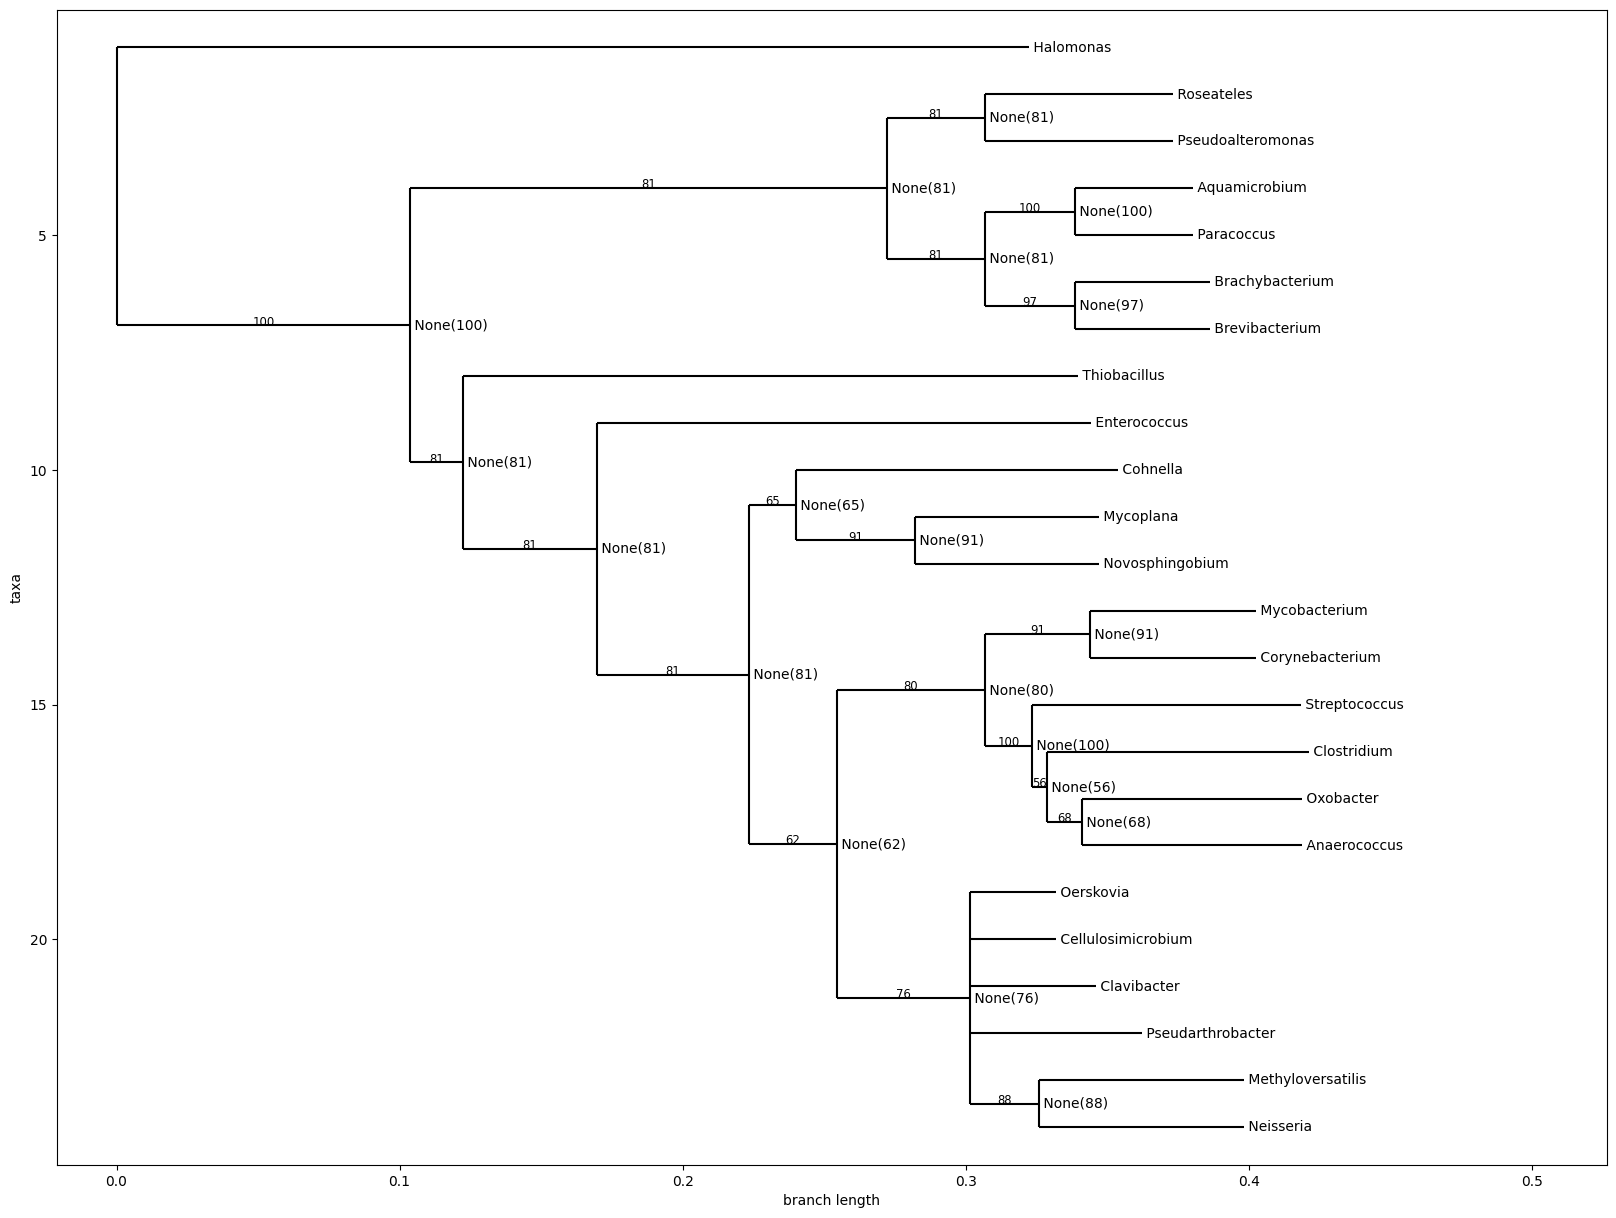

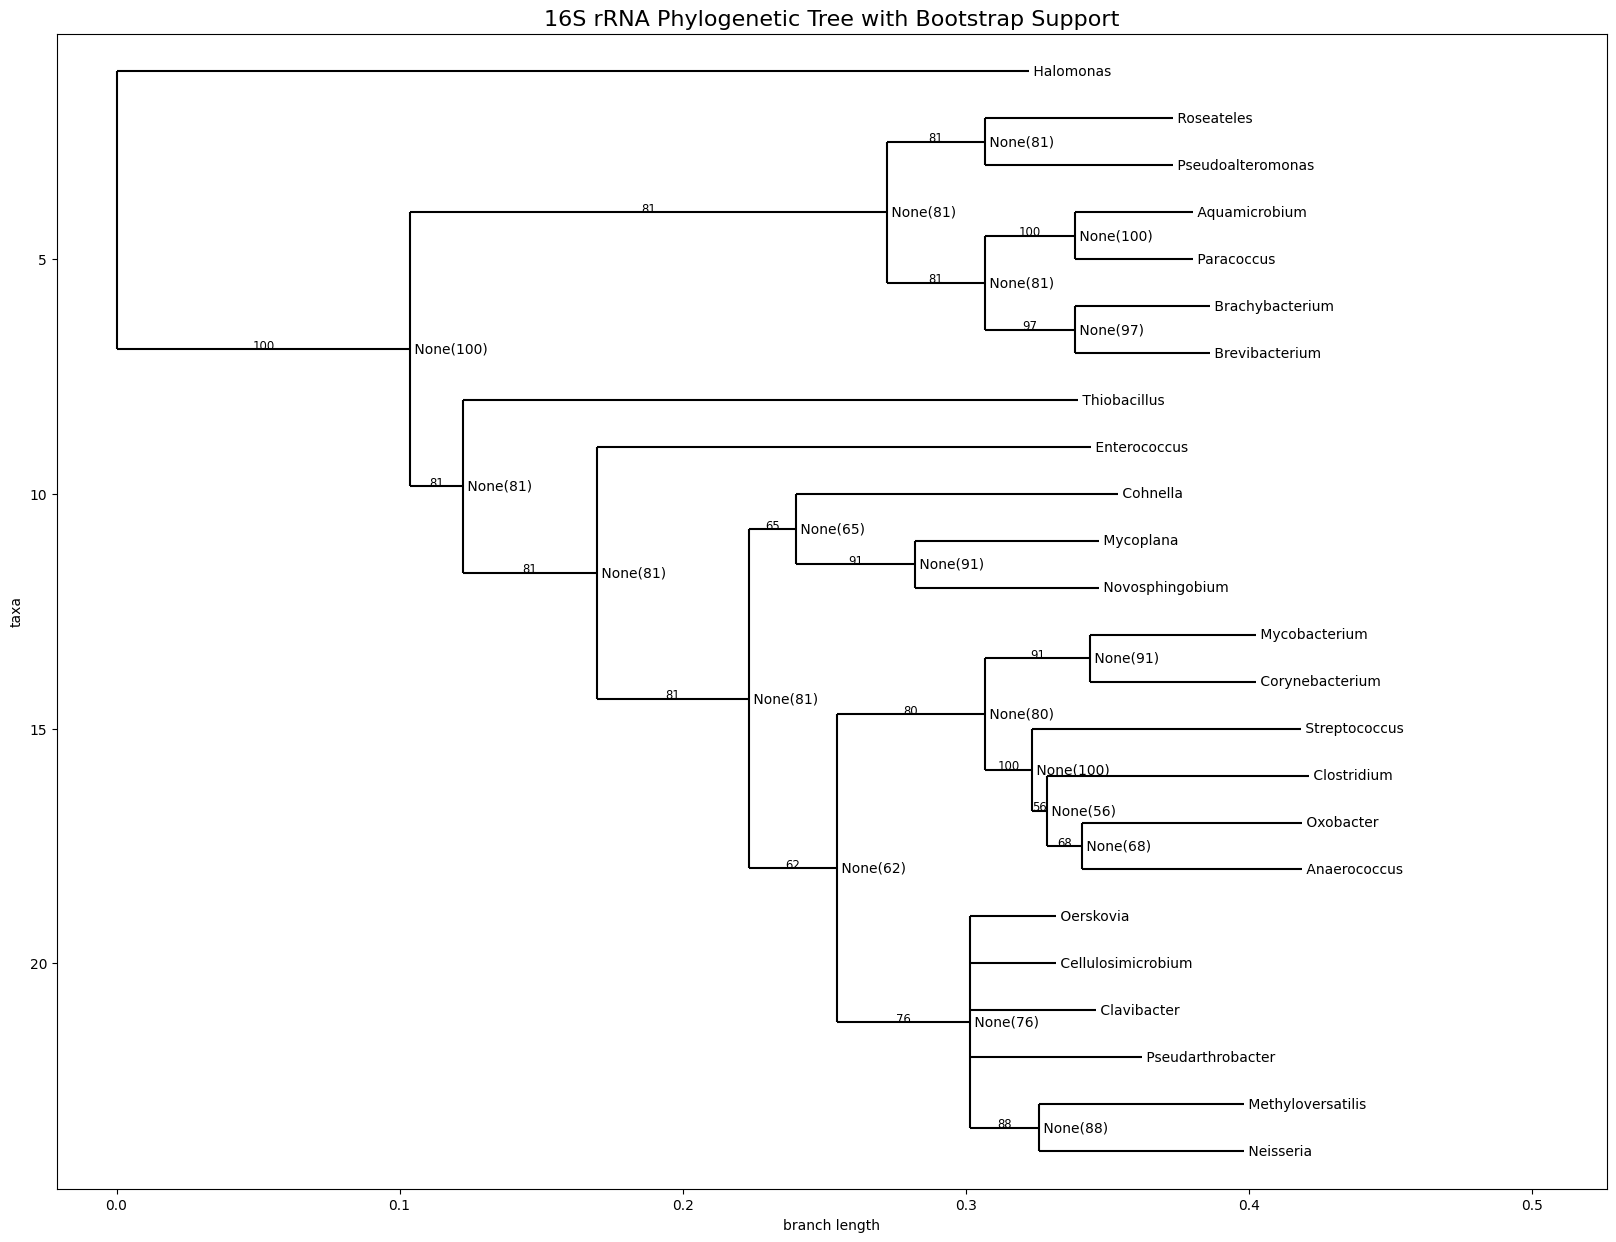

In [ ]:
def plot_tree_with_annotations(consensus_tree, ax):
        
    # Draw tree with bootstrap values
    Phylo.draw(consensus_tree, 
               axes = ax, 
               show_confidence=True,
               label_func=lambda x: f"{x.name}" if x.confidence else x.name
    )

# Create the figure and axes outside the function
fig, ax = plt.subplots(figsize=(20, 15))

# Call the function, passing the external ax
plot_tree_with_annotations(consensus_tree, ax)

# Explicitly set the current axes to ensure the title is added to the correct subplot
plt.sca(ax)  # Set the current axes to `ax`
ax.set_title("16S rRNA Phylogenetic Tree with Bootstrap Support", fontsize=16)

# Display the plot
plt.show()

# 9. Interpretation of the Concensus Tree
High Confidence Clades: Clades with 100% bootstrap support, such as the one containing 'Haemophilus' and 'Legionella', are highly reliable. This indicates that these taxonomic groupings are very likely to be accurate.

Moderate Confidence Clades: The clade with a bootstrap value of 68%, containing 'Oxobacter' and 'Pseudarthrobacter', has moderate support. While this is generally considered to be a lower limit for strong support, it still suggests that this grouping is more likely to be true than not.

Taxonomic Implications: The high bootstrap values for clades containing genera like 'Haemophilus', 'Legionella', 'Roseococcus', etc., may have implications for our understanding of the relationships among these bacteria. For example, it could suggest that 'Haemophilus' and 'Legionella' share a more recent common ancestor with each other than with other genera in the tree.

Data Quality: High bootstrap values across the tree also speak to the quality of our sequence data and the alignment, suggesting that the results are not artifacts of poor data or methodology.

In [258]:
'''# Debugging
# check the function to generate replicates
for replicate in bootstrap_replicates:
    print(replicate)
# Store the concatenated replicates in the dictionary
bootstrap_replicates[0] = concatenated_replicates

# Print first bootstrap replicate to check
print('First bootstrap replicate:', bootstrap_replicates[0])
print("Number of sequences in alignment:", len(alignment))
print("IDs of sequences in alignment:", [record.id for record in alignment])

# # Tree basic info
for i, tree in enumerate(trees):
    print(f"Tree {i}: {tree}")
from Bio.Phylo.BaseTree import Tree
#Are the trees objects?
for i, tree in enumerate(trees):
    if not isinstance(tree, Tree):
        print(f"The element at index {i} is not a Tree object.")
        # Is the trees list empty?
if not trees:
    print("The list of trees is empty.")'''

'# Debugging\n# check the function to generate replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)\n# Store the concatenated replicates in the dictionary\nbootstrap_replicates[0] = concatenated_replicates\n\n# Print first bootstrap replicate to check\nprint(\'First bootstrap replicate:\', bootstrap_replicates[0])\nprint("Number of sequences in alignment:", len(alignment))\nprint("IDs of sequences in alignment:", [record.id for record in alignment])\n\n# # Tree basic info\nfor i, tree in enumerate(trees):\n    print(f"Tree {i}: {tree}")\nfrom Bio.Phylo.BaseTree import Tree\n#Are the trees objects?\nfor i, tree in enumerate(trees):\n    if not isinstance(tree, Tree):\n        print(f"The element at index {i} is not a Tree object.")\n        # Is the trees list empty?\nif not trees:\n    print("The list of trees is empty.")'

# 10. Summarising the Results

In [259]:
def summarize_analysis(final_sequences, consensus_tree, output_dir):
    """Generate analysis summary"""
    summary = {
        'total_genera': len(final_sequences['Genus'].unique()),
        'sequences_retrieved': len(final_sequences),
        'avg_sequence_length': round(final_sequences['Sequence'].str.len().mean(), 4),
        'genera_list': ', '.join(final_sequences['Genus'].unique())
    }
    
    # Save summary
    with open(output_dir / 'analysis_summary.txt', 'w') as f:
        for key, value in summary.items():
            f.write(f"{key}: {value}\n")
            
    return summary

In [260]:
Summary = summarize_analysis(final_sequences, consensus_tree, base_dir)
Summary

{'total_genera': 26,
 'sequences_retrieved': 26,
 'avg_sequence_length': 1254.6923,
 'genera_list': 'Aquamicrobium, Azospira, Brachybacterium, Brevibacterium, Bulleidia, Cellulosimicrobium, Clavibacter, Clostridium, Cohnella, Corynebacterium, Enterococcus, Halomonas, Methyloversatilis, Mycobacterium, Mycoplana, Novosphingobium, Oerskovia, Opitutus, Oxobacter, Paracoccus, Prevotella, Pseudarthrobacter, Pseudoalteromonas, Roseateles, Streptococcus, Thiobacillus'}

In [261]:
# Save the tree in Newick format
Phylo.write([consensus_tree], 'data_tree/consensus_tree.newick', 'newick')

1